<a href="https://colab.research.google.com/github/SabastianGu/ML_prediction_analysis_practice/blob/main/NLP_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
!wget https://lazyprogrammer.me/course_files/exercises/AirlineSentimentTweets.csv

--2024-12-18 17:12:47--  https://lazyprogrammer.me/course_files/exercises/AirlineSentimentTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineSentimentTweets.csv.5’

AirlineSentimentTwe 100%[===================>]   3.26M  --.-KB/s    in 0.06s   

2024-12-18 17:12:48 (59.0 MB/s) - ‘AirlineSentimentTweets.csv.5’ saved [3421431/3421431]



In [95]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import re
from sklearn.feature_extraction.text import TfidfVectorizer


plt.style.use('ggplot')
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [96]:
data = pd.read_csv('AirlineSentimentTweets.csv', nrows = 1000)
#data['id'] = range(0, len(data))
data.reset_index(drop=True, inplace = True)
df = data[['tweet_id','airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'text']]


def clean_data(review):

    no_punc = re.sub(r'[^\w\s]', '', review)
    no_digits = ''.join([i for i in no_punc if not i.isdigit()])

    return(no_digits)

df['text'] = df['text'].str.replace(r'@\w+', '', regex=True)
df['text'] = df['text'].apply(clean_data)
df['sentiment'] = df['airline_sentiment'].map({'negative': 0, 'positive': 1, 'neutral': 2})
df = df[['tweet_id', 'text', 'sentiment']]

# Creating one df for training and validation sets, and df_test for final tests
df = df.head(800)
df_test = df.tail(200)

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

X = tfidf.fit_transform(df['text'])

Y = to_categorical(df['sentiment'], num_classes = 3)
X_train, X_valid, y_train, y_valid = train_test_split(df['text'], Y, test_size = 0.33)
X_test = df_test['text']
y_test = to_categorical(df_test['sentiment'], num_classes = 3)




<ipython-input-96-0478d4c96ad6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.replace(r'@\w+', '', regex=True)
<ipython-input-96-0478d4c96ad6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(clean_data)
<ipython-input-96-0478d4c96ad6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [97]:
X_train

,text
324,thanks
625,So do I need to book two one ways in order fo...
519,So I can buy tix days before flight but can...
275,shares up on Q results httptcoXZqeGnef
12,This is such a great deal Already thinking ab...
...,...
475,Dad on Segway is the best part of this whole ...
173,congrats you just got all my business from EW...
769,good to know you will open the closed doors f...
438,I miss the nerdbird in San Jose


## Tokenizing by adding indexes, classical way

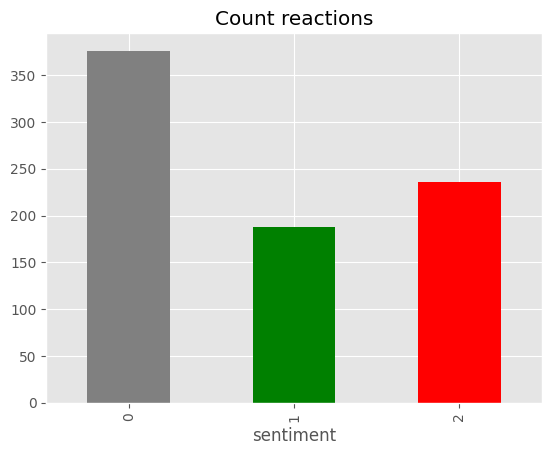

In [98]:
ax = df['sentiment'].value_counts().sort_index().plot(
    kind = 'bar',
    tick_label = ['neutral', 'positive', 'negative'], color = ['grey', 'green', 'red'],
    title = 'Count reactions',
)


In [99]:
MAX_VOC = 20000
tokenizer = Tokenizer(num_words = MAX_VOC)
tokenizer.fit_on_texts(X_train)
train_sequence = tokenizer.texts_to_sequences(X_train)
valid_sequence = tokenizer.texts_to_sequences(X_valid)
test_sequence = tokenizer.texts_to_sequences(X_test)
word2idx = tokenizer.word_index
V = len(word2idx)
print("Unique tokens found:", V)

print('padding sequences to make N x T')
data_train = pad_sequences(train_sequence)
T = data_train.shape[1]
data_valid = pad_sequences(valid_sequence, maxlen = T)
data_test = pad_sequences(test_sequence, maxlen = T)
print('data_train.shape:', data_train.shape, y_train, 'data_valid.shape:', data_valid.shape, 'data_test.shape:', data_test.shape)

Unique tokens found: 1977
padding sequences to make N x T
data_train.shape: (536, 30) [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]] data_valid.shape: (264, 30) data_test.shape: (200, 30)


In [100]:
import tqdm

def generate_training_data(sequences, vocab_size, window_size,num_ns, seed):
  targets, contexts, labels = [], [], []
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm.tqdm(sequences):
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

train_targets, train_context, train_labels = generate_training_data(train_sequence, V+1, 5, 1, 72)
valid_targets, valid_conext, valid_labels = generate_training_data(valid_sequence, V+1, 5, 1, 72)

100%|██████████| 264/264 [00:02<00:00, 121.90it/s]


In [101]:
train_targets = np.array(train_targets) # Continue from here 11.12.2024
train_contexts = np.array(train_context)
train_labels = np.array(train_labels)

valid_targets = np.array(valid_targets)
valid_contexts = np.array(valid_conext)
valid_labels = np.array(valid_labels)

BATCH_SIZE = 64
BUFFER_SIZE = 124

train_dataset = tf.data.Dataset.from_tensor_slices(((train_targets, train_contexts), train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)

valid_dataset = tf.data.Dataset.from_tensor_slices(((valid_targets, valid_contexts,), valid_labels))
valid_dataset = valid_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)
print(train_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(64,), dtype=tf.int64, name=None), TensorSpec(shape=(64, 2), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 2), dtype=tf.int64, name=None))>


In [102]:
train_dataset = train_dataset.cache().prefetch(buffer_size = BATCH_SIZE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size = BATCH_SIZE)

In [103]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                                      name = "w2v_embedding")

    self.context_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)


  def call(self, pair):
    target, context = pair
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis = 1)
    word_emb = self.target_embedding(target)
    context_emb = self.context_embedding(context)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    return dots

  def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [104]:
embedding_dim = 256
word2v = Word2Vec(V+1, embedding_dim)
word2v.compile(optimizer = 'adam',
               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
               metrics = ['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs')

word2v.fit(train_dataset, epochs = 30, callbacks = [tensorboard_callback])
word2v.save_weights('./word2vec_model.weights.h5')


Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4937 - loss: 0.6934
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9798 - loss: 0.6625
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.6104
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.5157
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.3908
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.2741
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.1873
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.1300
Epoch 9/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0936
Epoch 10/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0701
Epoch 11/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0546
Epoch 12/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


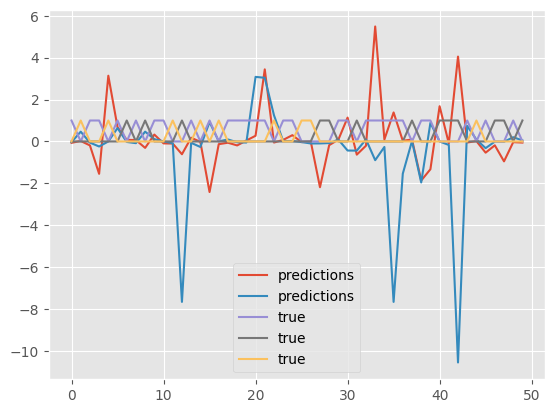

In [105]:
weights =  word2v.get_layer('w2v_embedding').get_weights()[0]

preds = word2v.predict(valid_dataset)

plt.plot(preds[:50], label = 'predictions')
plt.plot(y_valid[:50], label = 'true')
plt.legend()


In [107]:
model = Sequential()
model.add(Embedding(input_dim = V+1, output_dim = 256, weights = [weights], trainable = True))
model.add(LSTM(64))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))


model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(data_train, y_train, validation_data = (data_test, y_test), epochs = 20)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4772 - loss: 1.0759 - val_accuracy: 0.7000 - val_loss: 0.8314
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6039 - loss: 0.8849 - val_accuracy: 0.7150 - val_loss: 0.7067
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7168 - loss: 0.7333 - val_accuracy: 0.7600 - val_loss: 0.6116
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7712 - loss: 0.5766 - val_accuracy: 0.7950 - val_loss: 0.4995
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9153 - loss: 0.3079 - val_accuracy: 0.8450 - val_loss: 0.4637
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9528 - loss: 0.1623 - val_accuracy: 0.8150 - val_loss: 0.5373
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9751 - loss: 0.0907 - val_accuracy: 0.8300 - val_loss: 0.5711
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9884 - loss: 0.0457 - val_accuracy: 0.8500 - v

## Tokenizing with NLTK

In [108]:
#Tokenizing with nltk

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


sia = SentimentIntensityAnalyzer()



res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  text = row['text']
  tweet_id = row['tweet_id']
  sentiment_score = sia.polarity_scores(text)
  res[tweet_id] = sentiment_score

res_test = {}
for i, row in tqdm(df_test.iterrows(), total = len(df_test)):
  text = row['text']
  tweet_id = row['tweet_id']
  sentiment_score = sia.polarity_scores(text)
  res_test[tweet_id] = sentiment_score

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [109]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index': 'tweet_id'})
vaders = vaders.merge(df, how = 'left')


In [110]:
vaders

,tweet_id,neg,neu,pos,compound,text,sentiment
0,570306133677760513,0.000,1.000,0.000,0.0000,What said,2
1,570301130888122368,0.000,1.000,0.000,0.0000,plus youve added commercials to the experienc...,1
2,570301083672813571,0.000,1.000,0.000,0.0000,I didnt today Must mean I need to take anothe...,2
3,570301031407624196,0.236,0.628,0.135,-0.2716,its really aggressive to blast obnoxious ente...,0
4,570300817074462722,0.351,0.649,0.000,-0.5829,and its a really big bad thing about it,0
...,...,...,...,...,...,...,...
795,570079237350100993,0.185,0.679,0.136,-0.3182,again I ask who can I call to get this fixed ...,0
796,570079041547472896,0.131,0.584,0.285,0.6369,Yo yo yo stuck on the tarmac for over hours ...,0
797,570078894008594432,0.166,0.834,0.000,-0.5563,its highly unprofessional for you to overbook...,0
798,570078733735821313,0.105,0.714,0.180,0.2500,well considering every agent before claimed t...,0


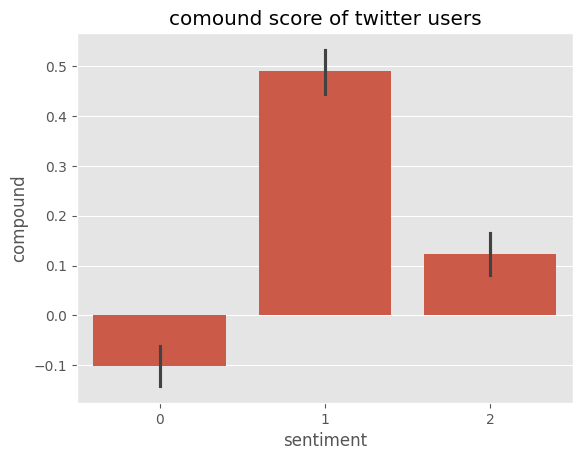

In [111]:
ax = sns.barplot(data = vaders, x = 'sentiment', y = 'compound')
ax.set_title('comound score of twitter users')
plt.show()

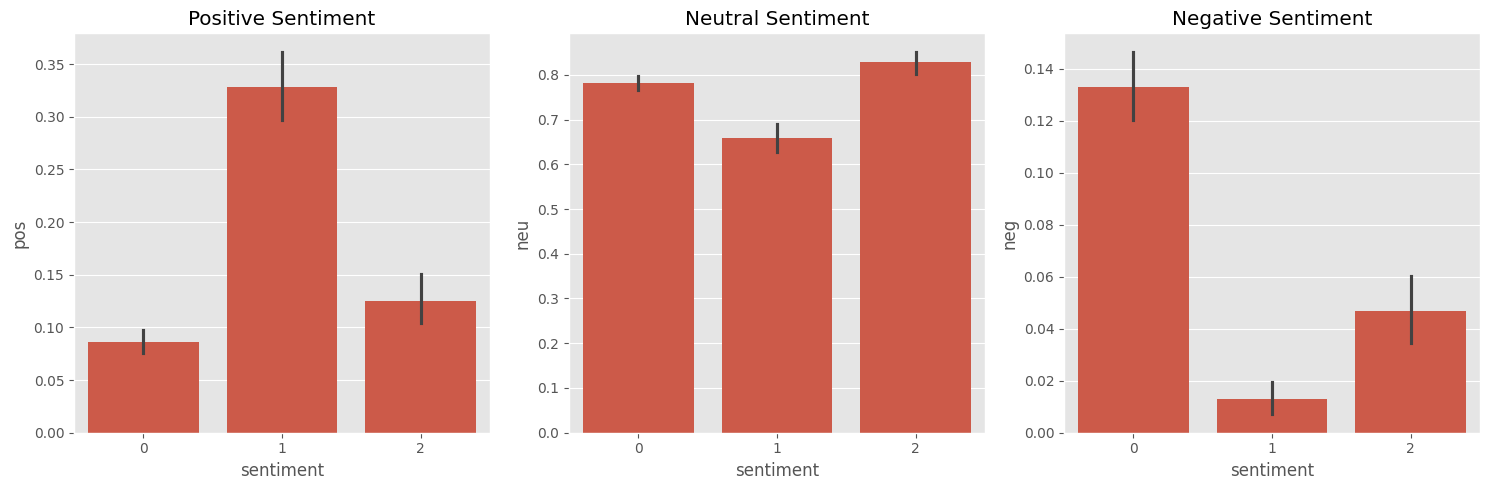

In [112]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
sns.barplot(data = vaders, x = 'sentiment', y = 'pos', ax = ax1)
sns.barplot(data = vaders, x = 'sentiment', y = 'neu', ax = ax2)
sns.barplot(data = vaders, x = 'sentiment', y = 'neg', ax = ax3)

ax1.set_title('Positive Sentiment')
ax2.set_title('Neutral Sentiment')
ax3.set_title('Negative Sentiment')

plt.tight_layout()
plt.show()

## Roberta comes to help

In [113]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [114]:
def polarity_scores_roberta(text):
  encoded_text = tokenizer(text, return_tensors = 'pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
      'roberta_neg' : scores[0],
      'roberta_neu' : scores[1],
      'roberta_pos' : scores[2]
  }
  return scores_dict

res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  text = row['text']
  tweet_id = row['tweet_id']
  vador_result = sia.polarity_scores(text)
  vader_result_rename = {}
  for key, value in vador_result.items():
    vader_result_rename[f"vader_{key}"] = value
  roberta_result = polarity_scores_roberta(text)
  both = {**vader_result_rename, **roberta_result}
  res[tweet_id] = both

res_test = {}
for i, row in tqdm(df_test.iterrows(), total = len(df_test)):
  text = row['text']
  tweet_id = row['tweet_id']
  vador_result = sia.polarity_scores(text)
  vader_result_rename = {}
  for key, value in vador_result.items():
    vader_result_rename[f"vader_{key}"] = value
  roberta_result = polarity_scores_roberta(text)
  both = {**vader_result_rename, **roberta_result}
  res_test[tweet_id] = both

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [115]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns= {'index': 'tweet_id'})
results_df = results_df.merge(df, how = 'left')

In [116]:
results_df

,tweet_id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,text,sentiment
0,570306133677760513,0.000,1.000,0.000,0.0000,0.265022,0.660006,0.074973,What said,2
1,570301130888122368,0.000,1.000,0.000,0.0000,0.719125,0.251994,0.028881,plus youve added commercials to the experienc...,1
2,570301083672813571,0.000,1.000,0.000,0.0000,0.267021,0.661283,0.071696,I didnt today Must mean I need to take anothe...,2
3,570301031407624196,0.236,0.628,0.135,-0.2716,0.928044,0.066091,0.005865,its really aggressive to blast obnoxious ente...,0
4,570300817074462722,0.351,0.649,0.000,-0.5829,0.901851,0.085615,0.012534,and its a really big bad thing about it,0
...,...,...,...,...,...,...,...,...,...,...
795,570079237350100993,0.185,0.679,0.136,-0.3182,0.949429,0.048028,0.002543,again I ask who can I call to get this fixed ...,0
796,570079041547472896,0.131,0.584,0.285,0.6369,0.893542,0.096272,0.010187,Yo yo yo stuck on the tarmac for over hours ...,0
797,570078894008594432,0.166,0.834,0.000,-0.5563,0.945943,0.050734,0.003324,its highly unprofessional for you to overbook...,0
798,570078733735821313,0.105,0.714,0.180,0.2500,0.783329,0.209010,0.007661,well considering every agent before claimed t...,0


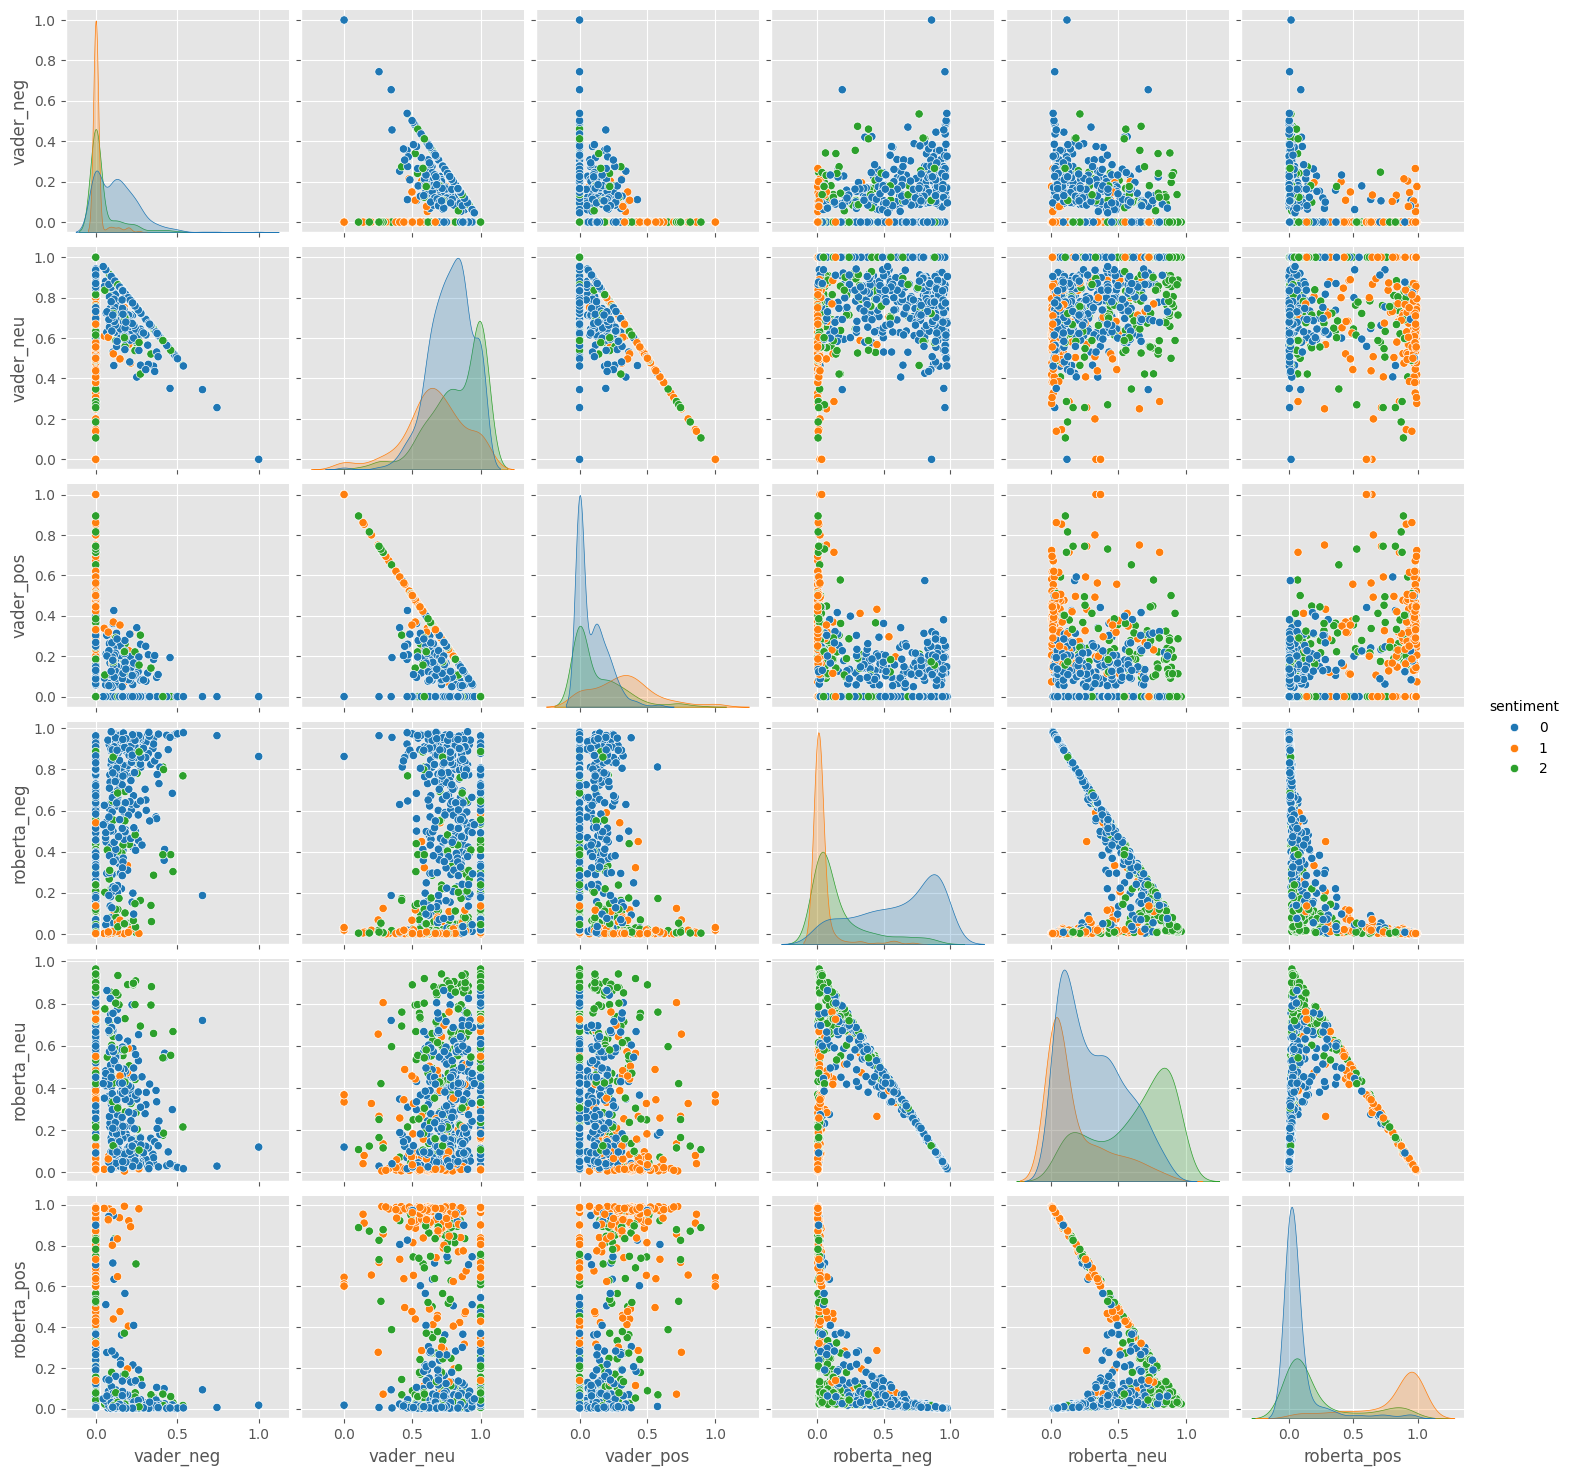

In [117]:
sns.pairplot(data = results_df, vars = ['vader_neg', 'vader_neu', 'vader_pos',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue = 'sentiment',
             palette = 'tab10')

In [118]:
df_roberta = results_df.drop(['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'sentiment'], axis = 1)
Y_roberta = to_categorical(results_df['sentiment'], num_classes = 3)

df_vador = results_df.drop(['roberta_neg', 'roberta_neu', 'roberta_pos', 'sentiment'], axis = 1)
Y_vador = to_categorical(results_df['sentiment'], num_classes = 3)

X_R_train, X_R_test, y_r_train, y_r_test = train_test_split(df_roberta, Y_roberta, test_size = 0.33)
X_V_train, X_V_test, y_v_train, y_v_test = train_test_split(df_vador, Y_vador, test_size = 0.33)

In [119]:
X_R_train

,tweet_id,roberta_neg,roberta_neu,roberta_pos,text
97,569907336485019648,0.506610,0.454695,0.038694,Let scanned in passengers leave the plane t...
602,570257564023128064,0.768950,0.215082,0.015967,dm these nuts
469,567810209088847873,0.011279,0.750645,0.238076,Man of steel flies to more cities thoughand w...
32,570088404156698625,0.758800,0.218955,0.022245,help left expensive headphones on flight IAD...
301,568824637267685377,0.631763,0.352851,0.015386,Do you guys know your checkin links from emai...
...,...,...,...,...,...
488,567769981128282113,0.012095,0.186391,0.801514,so loyal that Im driving to NYC from PA to fl...
541,570288349392605186,0.135102,0.813673,0.051225,Newarkliberty Airport need to indicate differ...
284,568865011717705730,0.016893,0.847646,0.135461,I need you to follow back in order to DM
532,570291866530398208,0.319114,0.659735,0.021151,and what am I suppose to do with that number


In [121]:
X_V_train

,tweet_id,vader_neg,vader_neu,vader_pos,vader_compound,text
778,570083898031513600,0.167,0.718,0.115,-0.2732,Im constantly having challenges with upgrades...
403,568199730989174784,0.000,0.723,0.277,0.3182,Really Sprint I thought you guys were kewl _
792,570079676204347394,0.163,0.837,0.000,-0.5095,were still waiting to find out your rep is wo...
30,570114021854212096,0.227,0.714,0.059,-0.6908,hi I just bked a cool birthday trip with you ...
139,569619569372823552,0.211,0.710,0.079,-0.5487,why cant we book seats on your flights when w...
...,...,...,...,...,...,...
310,568795484283736064,0.268,0.732,0.000,-0.2960,missed my flight How does standby work
6,570300616901320704,0.000,0.803,0.197,0.4019,yes nearly every time I fly VX this ear worm ...
219,569226875349835776,0.174,0.637,0.189,0.0772,I did it but there was a problem in the link ...
713,570151672070205440,0.000,0.936,0.064,0.0772,has not responded to my various requests for ...
